In [1]:
import re
import string
import zipfile
from collections import Counter
from itertools import chain

import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    log_loss, roc_auc_score, confusion_matrix, roc_curve, auc, 
    classification_report
)
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
from xgboost import XGBClassifier

# Natural language processing
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import spacy

# Utility libraries
from tqdm import tqdm
import joblib

# Custom utility modules
from utils.plot_utils import plot_count_distribution, class_distribution
from utils.metrics_utils import display_metrics, plot_confusion_matrix, plot_roc_curve

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Galyna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Galyna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Galyna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Inspection

In [125]:
df_train = pd.read_csv('data/quora_train.csv.zip', index_col=0)
pd.set_option('display.max_colwidth', None)

In [126]:
df_train.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three independent variables is also independent?,0
196656,297402,297403,What is practical management and what is strategic management?,What are the practical aspects of strategic management?,0
113125,184949,184950,How useful is MakeUseOf Answers?,"Is there any Q&A site that is not Yahoo answers, where hate speech is allowed?",0
266232,101283,163744,Which is the best place to reside in India and Why?,Which ia the best place to visit in India?,0
122738,17811,27517,Why do so many people ask questions on Quora that can be easily answered by any number of legitimate sources on the Web? Have they not heard of Google or Bing?,Why don't many people posting questions on Quora check Google first?,1


In [127]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323432 entries, 332278 to 402019
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          323432 non-null  int64 
 1   qid2          323432 non-null  int64 
 2   question1     323431 non-null  object
 3   question2     323430 non-null  object
 4   is_duplicate  323432 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 14.8+ MB


In [128]:
df_train = df_train.dropna(subset=['question1', 'question2'])

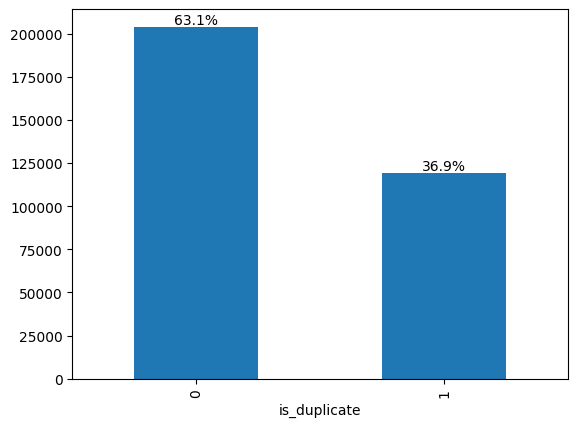

In [129]:
class_distribution(df_train, 'is_duplicate')

#### Let's look at the test dataset to make sure it doesn't have missing values and check whether the distribution of classes is the same.   

In [55]:
df_test = pd.read_csv('data/quora_test.csv.zip', index_col=0)
pd.set_option('display.max_colwidth', None)

In [56]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80858 entries, 305985 to 7415
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   qid1          80858 non-null  int64 
 1   qid2          80858 non-null  int64 
 2   question1     80858 non-null  object
 3   question2     80858 non-null  object
 4   is_duplicate  80858 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.7+ MB


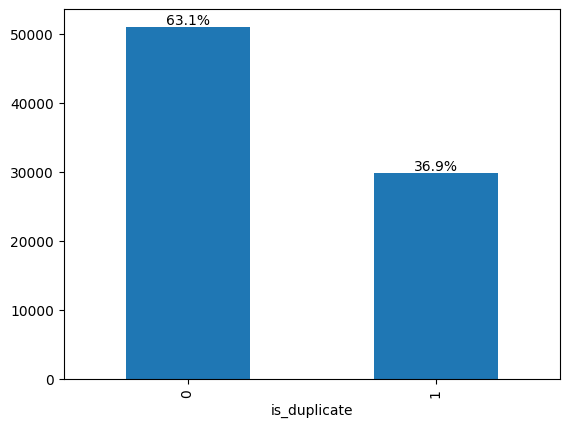

In [57]:
class_distribution(df_test, 'is_duplicate')

### Questions Appearing More Than Once

Let's explore how many unique questions appear more than once in the dataset (considering both question1 and question2).

In [58]:
# Combine all questions into a single Series
all_questions = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist())

# Count occurrences of each question
question_counts = all_questions.value_counts()

# Questions that appear more than once
repeated_questions = question_counts[question_counts > 1]

print(f"Total unique questions: {question_counts.shape[0]}")
print(f"Questions appearing more than once: {repeated_questions.shape[0]}")
print(f"Percentage of repeated questions: {repeated_questions.shape[0] / question_counts.shape[0] * 100:.2f}%")

# Show a few examples
print("\nSample repeated questions:")
print(repeated_questions.head(10))

Total unique questions: 449361
Questions appearing more than once: 85992
Percentage of repeated questions: 19.14%

Sample repeated questions:
What are the best ways to lose weight?                                                                                        126
How can you look at someone's private Instagram account without following them?                                               103
How can I lose weight quickly?                                                                                                 83
What's the easiest way to make money online?                                                                                   74
What are some things new employees should know going into their first day at AT&T?                                             64
Can you see who views your Instagram?                                                                                          61
What do you think of the decision by the Indian Government to demonetize 500 a

Let's have a look at how the same question can be rephrased. 

In [130]:
matching_questions = df_train[
    (df_train['question1'] == "What are the best ways to lose weight?") |
    (df_train['question2'] == "What are the best ways to lose weight?")
]
matching_questions[matching_questions['is_duplicate'] == 1].value_counts().head(10)

qid1  qid2    question1                               question2                                                           is_duplicate
2559  2711    What are the best ways to lose weight?  What is the best method of losing weight?                           1               1
      2712    What are the best ways to lose weight?  What are the best way of loose the weight?                          1               1
      114804  What are the best ways to lose weight?  What is the best way to reduce weight?                              1               1
      99661   What are the best ways to lose weight?  How do I reduce my weight?                                          1               1
      88319   What are the best ways to lose weight?  What is the best guide to lose unwanted pounds?                     1               1
      82022   What are the best ways to lose weight?  What are the best ways to lose weight? What is the best diet plan?  1               1
      80153   What are th

In [131]:
matching_questions[matching_questions['is_duplicate'] == 0].value_counts().head(10)

qid1    qid2  question1                                                                                                                                       question2                               is_duplicate
960     2559  Is it safe to lose 25 pounds in 1 month?                                                                                                        What are the best ways to lose weight?  0               1
263860  2559  What are some healthy ways you can lose 35 pounds in 3 months?                                                                                  What are the best ways to lose weight?  0               1
320617  2559  Does an exercise bicycle help you lose weight?                                                                                                  What are the best ways to lose weight?  0               1
320076  2559  How can I loose 10 kgs in 40 days?                                                                                             

## Text Length Analysis

Analyzing the distribution of word and character counts in questions.

In [132]:
df_train['question1_word_count'] = df_train['question1'].apply(lambda x: len(str(x).split()))
df_train['question2_word_count'] = df_train['question2'].apply(lambda x: len(str(x).split()))

In [133]:
df_train['question1_character_count'] = df_train['question1'].apply(lambda x: len(str(x)))
df_train['question2_character_count'] = df_train['question2'].apply(lambda x: len(str(x)))

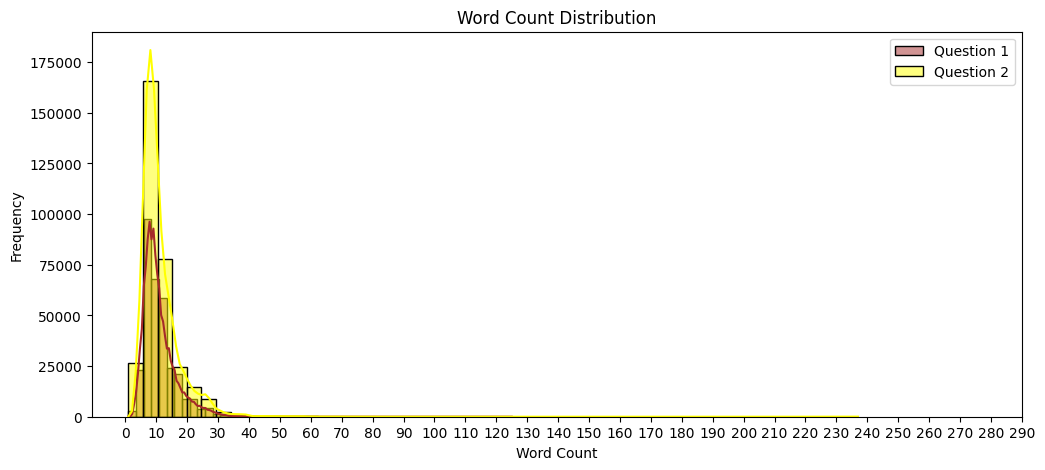

In [134]:
# Plot word count distributions
plt.figure(figsize=(12, 5))
sns.histplot(df_train['question1_word_count'], bins=50, kde=True, color='brown', label='Question 1')
sns.histplot(df_train['question2_word_count'], bins=50, kde=True, color='yellow', label='Question 2')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xticks(range(0, 300, 10))
plt.legend()
plt.show()

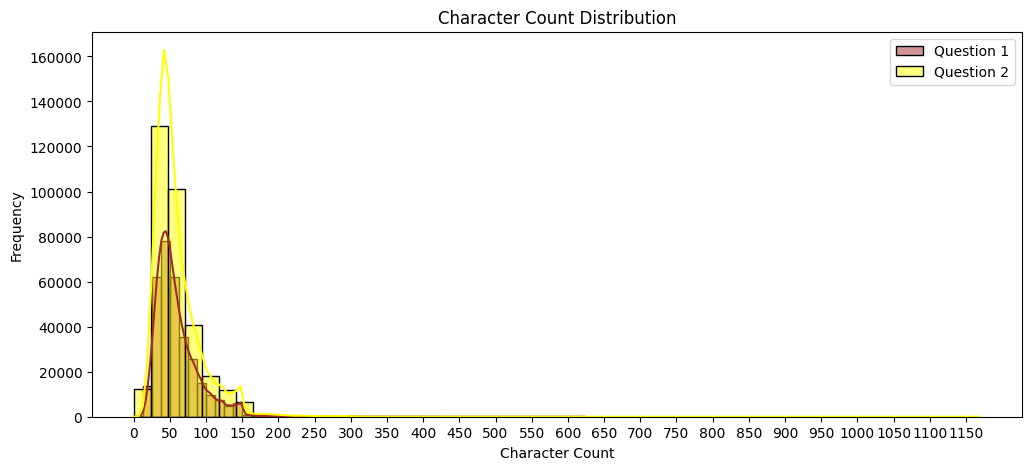

In [64]:
# Plot character count distributions
plt.figure(figsize=(12, 5))
sns.histplot(df_train['question1_character_count'], bins=50, kde=True, color='brown', label='Question 1')
sns.histplot(df_train['question2_character_count'], bins=50, kde=True, color='yellow', label='Question 2')
plt.title('Character Count Distribution')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.xticks(range(0, 1200, 50))
plt.legend()
plt.show()

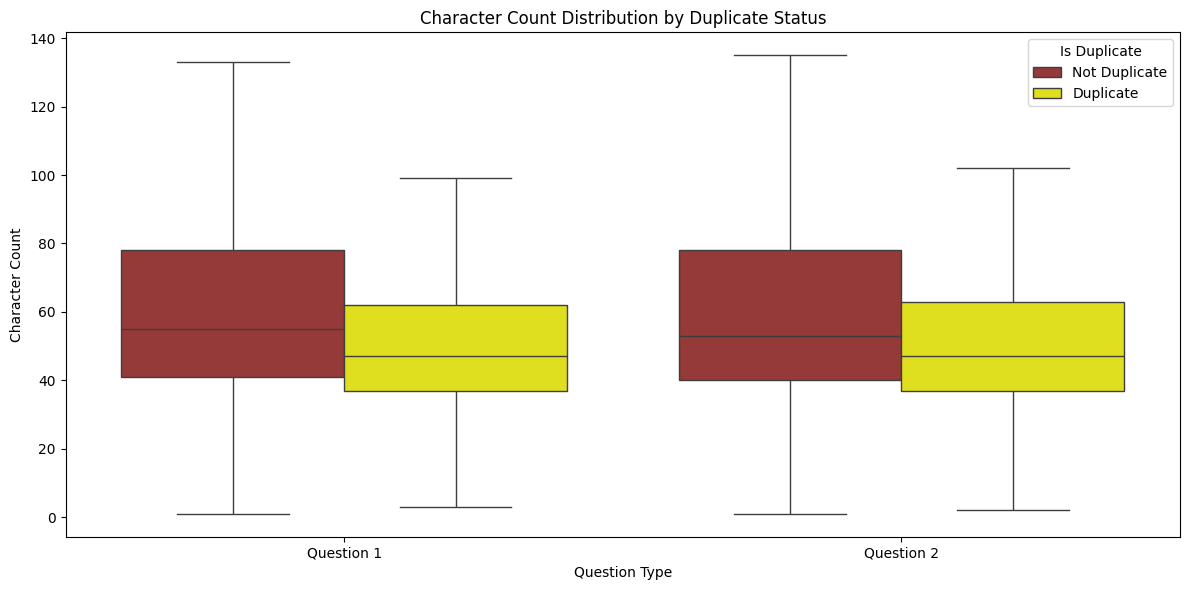

In [65]:
plot_count_distribution(
    df=df_train, 
    col1='question1_character_count', 
    col2='question2_character_count', 
    label_col='is_duplicate',
    count_label="Character Count",
    title="Character Count Distribution by Duplicate Status"
)

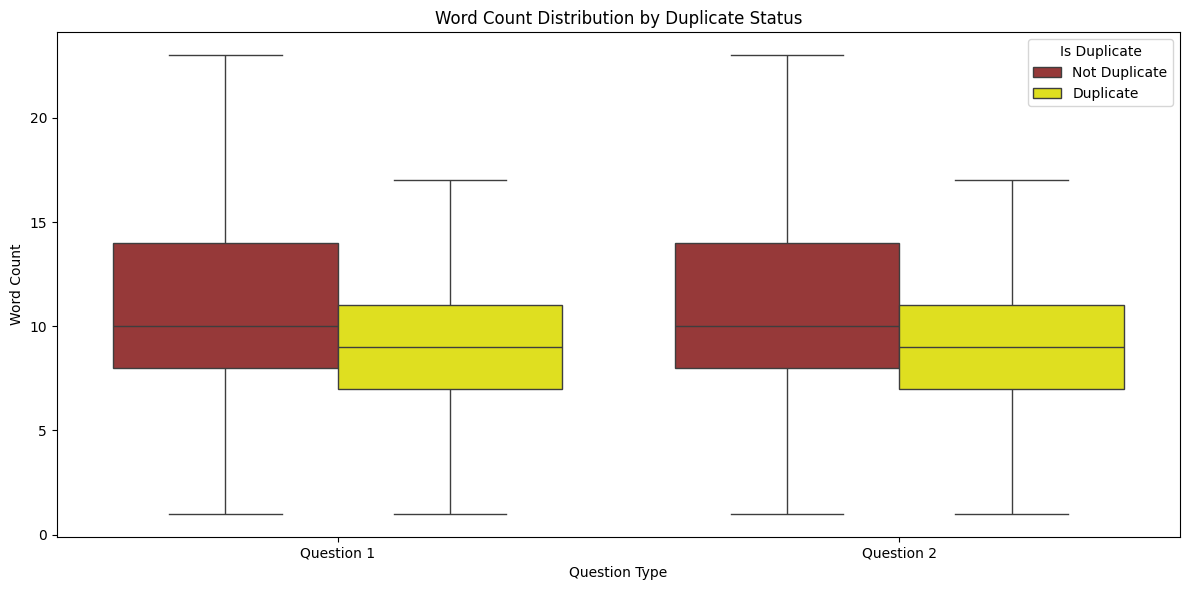

In [66]:
plot_count_distribution(
    df=df_train, 
    col1='question1_word_count', 
    col2='question2_word_count', 
    label_col='is_duplicate',
    count_label="Word Count",
    title="Word Count Distribution by Duplicate Status"
)

## Question Characteristics Analysis

Analyzing special patterns and characteristics in questions (question marks, math tags, etc.)

In [67]:
# Analyze special patterns and characters in questions
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist())
wh_words  = {'what', 'how', 'why', 'where', 'when', 'which'}

qmarks = np.mean(train_qs.apply(lambda x: '?' in str(x)))
math = np.mean(train_qs.apply(lambda x: '[math]' in str(x)))
fullstop = np.mean(train_qs.apply(lambda x: '.' in str(x)))
capital_first = np.mean(train_qs.apply(lambda x: str(x)[0].isupper() if len(str(x)) > 0 else False))
capitals = np.mean(train_qs.apply(lambda x: any([y.isupper() for y in str(x)])))
numbers = np.mean(train_qs.apply(lambda x: any([y.isdigit() for y in str(x)])))
wh_start = np.mean(train_qs.apply(lambda x: str(x).split() 
                                    and str(x).split()[0].lower() in wh_words))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))
print('Starts with WH-word: {:.2f}%'.format(wh_start * 100))

Questions with question marks: 99.88%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.82%
Questions with capital letters: 99.95%
Questions with numbers: 11.85%
Starts with WH-word: 71.61%


### Most Common and Unique Words

Let's analyse which words are most common in the dataset and how many words are unique. 

In [135]:
all_text = df_train['question1'].fillna('') + ' ' + df_train['question2'].fillna('')
words = all_text.str.lower().str.split()
flat_words = list(chain.from_iterable(words))
word_counts = Counter(flat_words)

In [69]:
word_counts.most_common(20)

[('the', 301023),
 ('what', 248836),
 ('is', 214821),
 ('how', 175295),
 ('i', 170695),
 ('a', 168388),
 ('to', 163514),
 ('in', 155567),
 ('of', 127084),
 ('do', 123789),
 ('are', 116548),
 ('and', 106316),
 ('can', 90979),
 ('for', 81364),
 ('you', 67804),
 ('why', 60200),
 ('my', 56786),
 ('best', 55778),
 ('it', 48641),
 ('on', 47423)]

In [136]:
num_unique_words = len(word_counts)
print(f"Number of unique words: {num_unique_words}")

Number of unique words: 178367


## Preprocessing and Feature Engineering

In [137]:
# Load English NLP model
nlp = spacy.load("en_core_web_sm")

In [138]:
KEEP_POS_TAGS = {"NOUN", "PROPN", "VERB", "ADV", "ADJ", "NUM", "PRON"}
IMPORTANT_WORDS = {"not", "no", "never", "should", "can", "how", "what", "why", "who", "when", "where", "which"}

In [139]:
KEEP_POS = {"NOUN", "PROPN", "VERB", "ADV", "ADJ"}
KEEP_STOP = {"not", "no", "never", "how", "what", "why",
             "who", "when", "where", "which", "should", "can"}

In [140]:
def filter_doc(doc):
    """
    Clean and filter a spaCy Doc object:
    - Keep wh-words and negations (if in KEEP_STOP)
    - Keep main content words (if in KEEP_POS and not a stop word)
    - Keep numbers
    - Remove punctuation
    - Handle empty or invalid input safely

    Parameters:
    -----------
    doc : spaCy Doc or str
        The parsed document.

    Returns:
    --------
    str
        A string of space-separated filtered tokens.
    """

    # Return empty string for NaN or None
    if doc is None or (isinstance(doc, float) and np.isnan(doc)):
        return ""

    tokens = []
    for tok in doc:
        # keep question words & negations even if they are stop-words
        if tok.text.lower() in KEEP_STOP:
            tokens.append(tok.lemma_.lower())
            continue

        # main content words
        if tok.pos_ in KEEP_POS and not tok.is_stop:
            lemma = tok.lemma_.lower()
            if lemma == "-pron-":
                lemma = tok.text.lower()
            tokens.append(lemma)

        # keep numbers
        elif tok.like_num:
            tokens.append(tok.text)

    # remove punctuation
    tokens = [t for t in tokens if t not in string.punctuation]
    return " ".join(tokens)

In [141]:
q1_texts = df_train["question1"].fillna("").tolist()
filtered_q1 = [filter_doc(doc) for doc in nlp.pipe(q1_texts, batch_size=1000)]

In [78]:
q2_texts = df_train["question2"].fillna("").tolist()
filtered_q2 = [filter_doc(doc) for doc in nlp.pipe(q2_texts, batch_size=1000)]

In [145]:
df_train['filtered_q1'] = filtered_q1
df_train['filtered_q2'] = filtered_q2

#### Let's look at the results of preprocessing: 

In [146]:
duplicate_df = df_train[df_train['is_duplicate'] == 1].copy()

for _, row in duplicate_df.head(5).iterrows():
    print(f"Q1 : {row['question1']}")
    print(f"→   {row['filtered_q1']}")
    print(f"Q2 : {row['question2']}")
    print(f"→   {row['filtered_q2']}")
    print("-" * 50)

Q1 : Why do so many people ask questions on Quora that can be easily answered by any number of legitimate sources on the Web? Have they not heard of Google or Bing?
→   why people ask question quora can easily answer number legitimate source web not hear google bing
Q2 : Why don't many people posting questions on Quora check Google first?
→   why people post question quora check google first
--------------------------------------------------
Q1 : What is the best small business to start in Nagpur?
→   what good small business start nagpur
Q2 : Which business/startup should I start in Nagpur which will have best chances of survival?
→   which business startup should start nagpur which good chance survival
--------------------------------------------------
Q1 : How can I open a PPF account? And what are its benefits?
→   how can open ppf account what benefit
Q2 : What is PPF account?
→   what ppf account
--------------------------------------------------
Q1 : What is the Sahara, and how 

In [147]:
def generate_engineered_features(df, q1_vecs, q2_vecs, vector_type='tfidf'):
    """
    Generate engineered features for question pairs including similarity and distance metrics.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame with columns 'question1' and 'question2'.
    q1_vecs : np.ndarray or sparse matrix
        Vector representations of question1 (TF-IDF or GloVe).
    q2_vecs : np.ndarray or sparse matrix
        Vector representations of question2 (TF-IDF or GloVe).
    vector_type : str, default='tfidf'
        Type of vectors provided: 'tfidf' (sparse) or 'glove' (dense).

    Returns:
    --------
    df : pandas.DataFrame
        DataFrame with new engineered feature columns added.
    """

    # --- Preprocessing: Ensure strings ---
    df['question1'] = df['question1'].astype(str)
    df['question2'] = df['question2'].astype(str)

    # --- Token-level Jaccard similarity ---
    def get_token_jaccard(row):
        tokens1 = set(row['question1'].lower().split())
        tokens2 = set(row['question2'].lower().split())
        return len(tokens1 & tokens2) / len(tokens1 | tokens2) if tokens1 | tokens2 else 0.0

    df['token_jaccard_sim'] = df.apply(get_token_jaccard, axis=1)

    # --- Word and character counts ---
    df['question1_word_count'] = df['question1'].apply(lambda x: len(x.split()))
    df['question2_word_count'] = df['question2'].apply(lambda x: len(x.split()))
    df['question1_character_count'] = df['question1'].apply(len)
    df['question2_character_count'] = df['question2'].apply(len)

    df['word_count_ratio'] = df['question1_word_count'] / df['question2_word_count'].replace(0, 1)
    df['char_count_ratio'] = df['question1_character_count'] / df['question2_character_count'].replace(0, 1)

    # --- Same starting word ---
    def same_start_word(q1, q2):
        try:
            return int(q1.split()[0].lower() == q2.split()[0].lower())
        except IndexError:
            return 0

    df['same_start_word'] = [
        same_start_word(q1, q2) for q1, q2 in zip(df['question1'], df['question2'])
    ]

    # --- Char n-gram similarity (trigrams, cosine) ---
    char_vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 3))
    char_vectorizer.fit(pd.concat([df['question1'], df['question2']]))

    q1_char_ngrams = char_vectorizer.transform(df['question1'])
    q2_char_ngrams = char_vectorizer.transform(df['question2'])

    df['char_ngram_sim'] = [
        cosine_similarity(q1_char_ngrams[i], q2_char_ngrams[i])[0, 0]
        for i in range(len(df))
    ]

    # --- Distance and similarity features ---
    if vector_type == 'glove':
        df['cosine_similarity'] = [
            cosine_similarity(q1_vecs[i].reshape(1, -1), q2_vecs[i].reshape(1, -1))[0, 0]
            for i in range(len(df))
        ]
        df['manhattan_dist'] = np.sum(np.abs(q1_vecs - q2_vecs), axis=1)
        df['euclidean_dist'] = np.linalg.norm(q1_vecs - q2_vecs, axis=1)

    elif vector_type == 'tfidf':
        batch_size = 10000
        num_batches = (len(df) + batch_size - 1) // batch_size
        cosine_sim = []

        for i in range(num_batches):
            start = i * batch_size
            end = min((i + 1) * batch_size, len(df))
            batch = linear_kernel(q1_vecs[start:end], q2_vecs[start:end])
            cosine_sim.extend(batch.diagonal())

        df['cosine_similarity'] = cosine_sim

        df['manhattan_dist'] = np.sum(np.abs(q1_vecs - q2_vecs), axis=1).A1  # Convert to flat array
        df['euclidean_dist'] = [
            np.linalg.norm(q1_vecs[i].toarray() - q2_vecs[i].toarray())
            for i in range(len(df))
        ]

    else:
        raise ValueError("vector_type must be either 'tfidf' or 'glove'")

    return df

#### Generating Features from Questions Using TF-IDF

In [148]:
# Fit the TF-IDF vectorizer on the combined filtered questions
tfidf = TfidfVectorizer()
tfidf.fit(pd.Series(filtered_q1 + filtered_q2))  # Combine for consistent vocabulary

# Transform each set of filtered questions separately
q1_tfidf = tfidf.transform(filtered_q1)
q2_tfidf = tfidf.transform(filtered_q2)

# Generate engineered features using the TF-IDF vectors
df_tfidf = generate_engineered_features(df_train.copy(), q1_tfidf, q2_tfidf, vector_type='tfidf')

In [149]:
df_tfidf.describe()

,qid1,qid2,is_duplicate,question1_word_count,question2_word_count,question1_character_count,question2_character_count,token_jaccard_sim,word_count_ratio,char_count_ratio,same_start_word,char_ngram_sim,cosine_similarity,manhattan_dist,euclidean_dist
count,323429.000000,323429.000000,323429.000000,323429.000000,323429.000000,323429.000000,323429.000000,323429.000000,323429.000000,323429.000000,323429.000000,323429.000000,323429.000000,323429.000000,323429.000000
mean,217325.780641,221047.527930,0.369200,10.941715,11.184554,59.531761,60.123242,0.325897,1.097246,1.110296,0.494718,0.511146,0.552763,2.238798,0.872322
std,157709.020406,159882.915531,0.482589,5.426282,6.312174,29.921286,33.889595,0.235491,0.565821,0.608005,0.499973,0.236532,0.291109,1.437662,0.365128
min,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.027027,0.006711,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74614.000000,74858.000000,0.000000,7.000000,7.000000,39.000000,39.000000,0.142857,0.785714,0.793103,0.000000,0.343415,0.351256,1.118137,0.647680
50%,192394.000000,197273.000000,0.000000,10.000000,10.000000,52.000000,51.000000,0.277778,1.000000,1.000000,0.000000,0.511199,0.578162,2.029099,0.918501
75%,346598.000000,354726.000000,1.000000,13.000000,13.000000,72.000000,72.000000,0.466667,1.250000,1.270833,1.000000,0.690066,0.790244,3.170127,1.138850
max,537932.000000,537933.000000,1.000000,125.000000,237.000000,623.000000,1169.000000,1.000000,31.000000,117.000000,1.000000,1.000000,1.000000,10.821717,1.414214


In [151]:
feature_cols = [
    'manhattan_dist',
    'euclidean_dist',
    'word_count_ratio',
    'char_count_ratio',
    'same_start_word',
    'char_ngram_sim',
    'token_jaccard_sim',
    'cosine_similarity' 
]

is_duplicate         1.000000
cosine_similarity    0.402484
char_ngram_sim       0.388363
token_jaccard_sim    0.340887
same_start_word      0.197480
word_count_ratio    -0.054650
char_count_ratio    -0.068302
euclidean_dist      -0.394170
manhattan_dist      -0.400929
Name: is_duplicate, dtype: float64


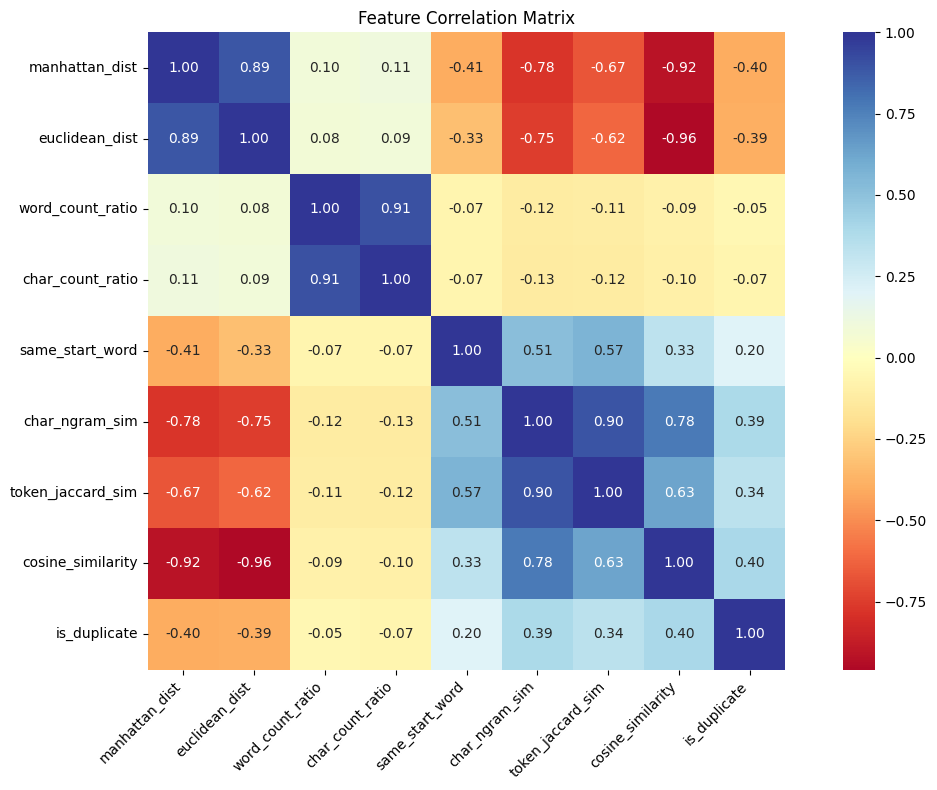

In [152]:
# Add target temporarily
features_with_target = feature_cols + ['is_duplicate']

# Correlation with target
correlations = df_tfidf[features_with_target].corr()['is_duplicate'].sort_values(ascending=False)
print(correlations)

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_tfidf[features_with_target].corr(), 
            cmap='RdYlBu', center=0,
            annot=True, fmt='.2f', square=True)
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

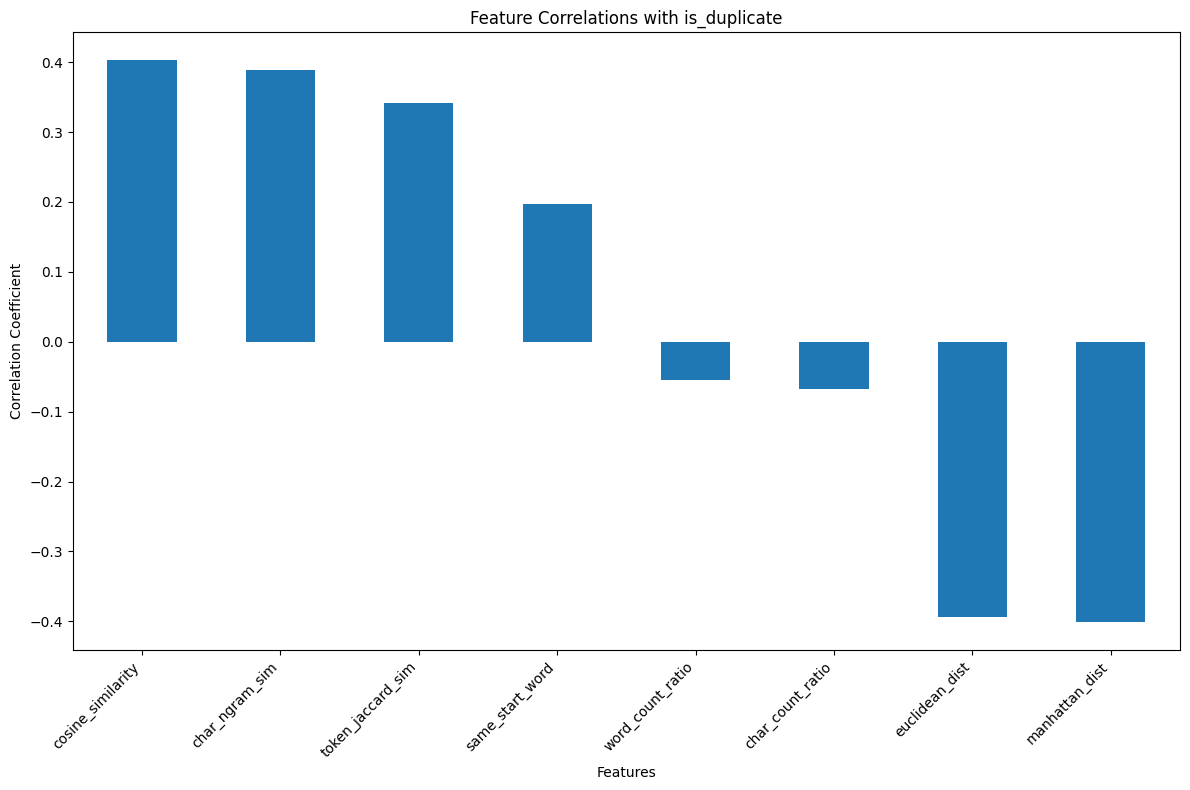

In [153]:
# Plot feature importance based on correlation (excluding target itself)
plt.figure(figsize=(12, 8))
correlations.drop('is_duplicate').plot(kind='bar')
plt.title('Feature Correlations with is_duplicate')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Let's do the same preprocessing for the test dataset. 

In [156]:
test_q1_texts = df_test["question1"].fillna("").tolist()
test_q2_texts = df_test["question2"].fillna("").tolist()

filtered_test_q1 = [filter_doc(doc) for doc in nlp.pipe(test_q1_texts, batch_size=1000)]
filtered_test_q2 = [filter_doc(doc) for doc in nlp.pipe(test_q2_texts, batch_size=1000)]

df_test['filtered_q1'] = filtered_test_q1
df_test['filtered_q2'] = filtered_test_q2

In [157]:
q1_test_tfidf = tfidf.transform(filtered_test_q1)
q2_test_tfidf = tfidf.transform(filtered_test_q2)

In [158]:
df_test_tfidf = generate_engineered_features(df_test.copy(), q1_test_tfidf, q2_test_tfidf, vector_type='tfidf')

### Logistic Regression with TF-IDF Features

Accuracy : 0.7945
Precision: 0.7351
Recall   : 0.6932
F1 Score : 0.7135
Log-Loss : 0.4192
ROC AUC  : 0.8789


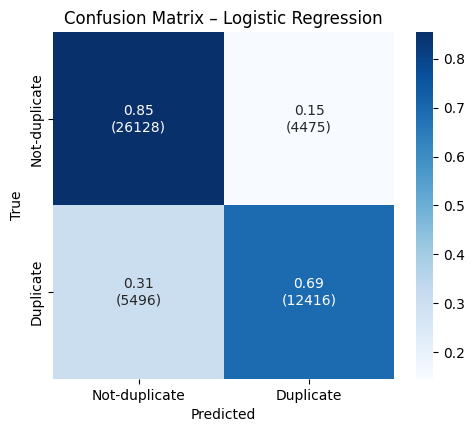

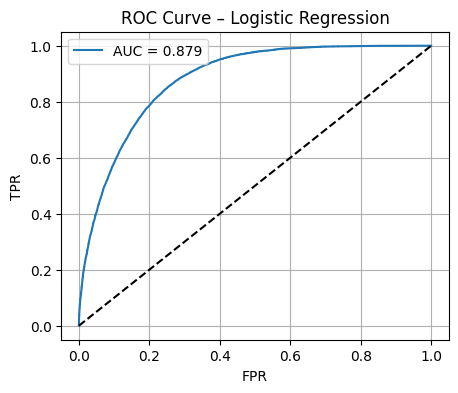

In [159]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_tfidf[feature_cols])

scaled_sparse = csr_matrix(scaled_features)

# Combine with TF-IDF vectors
X_tfidf = hstack([q1_tfidf, q2_tfidf, scaled_sparse])
y = df_train['is_duplicate']

# Split data into train and val sets
X_train, X_val, y_train, y_val = train_test_split(
    X_tfidf, y, test_size=0.15, random_state=42, stratify=y
)

# Train logistic regression model
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr.predict(X_val)
y_proba = lr.predict_proba(X_val)[:, 1]

# Evaluate 
display_metrics(y_val, y_pred, y_proba)

plot_confusion_matrix(
    y_val, y_pred,
    labels=['Not-duplicate', 'Duplicate'],
    title='Confusion Matrix – Logistic Regression'
)

plot_roc_curve(
    y_val, y_proba,
    title='ROC Curve – Logistic Regression'
)

#### Let's evaluate the model on the test dataset

In [160]:
scaled_test_features = scaler.transform(df_test_tfidf[feature_cols])
scaled_test_sparse = csr_matrix(scaled_test_features)

In [161]:
X_test = hstack([q1_test_tfidf, q2_test_tfidf, scaled_test_sparse])

y_test_pred = lr.predict(X_test)
y_test_proba = lr.predict_proba(X_test)[:, 1]

Accuracy : 0.7924
Precision: 0.7315
Recall   : 0.6915
F1 Score : 0.7110
Log-Loss : 0.4262
ROC AUC  : 0.8749


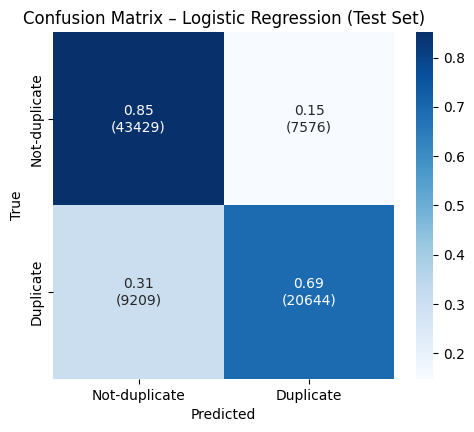

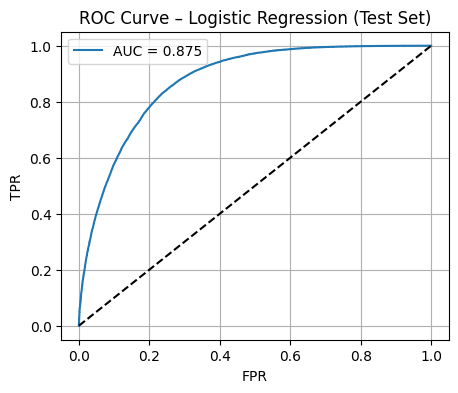

In [162]:
# Evaluate on test set
display_metrics(df_test['is_duplicate'], y_test_pred, y_test_proba)

plot_confusion_matrix(
    df_test['is_duplicate'], y_test_pred,
    labels=['Not-duplicate', 'Duplicate'],
    title='Confusion Matrix – Logistic Regression (Test Set)'
)

plot_roc_curve(
    df_test['is_duplicate'], y_test_proba,
    title='ROC Curve – Logistic Regression (Test Set)'
)

### XGBoost Model with TF-IDF Features

c:\Users\Galyna\anaconda3\envs\ml2025\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:41:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy : 0.7965
Precision: 0.7329
Recall   : 0.7061
F1 Score : 0.7192
Log-Loss : 0.3990
ROC AUC  : 0.8877


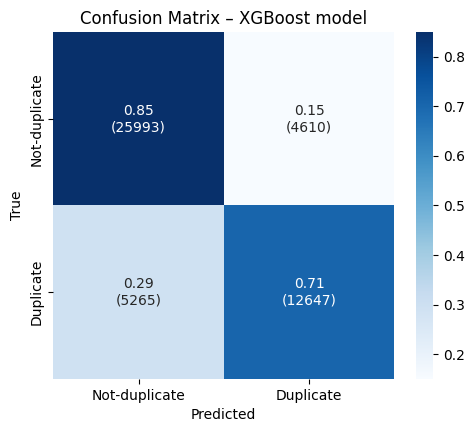

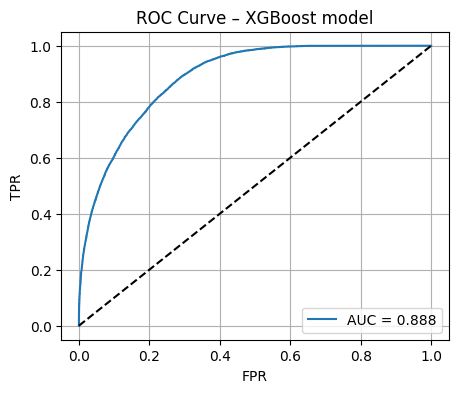

In [163]:
# Train XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict and evaluate
xgb_pred = xgb.predict(X_val)
xgb_proba = xgb.predict_proba(X_val)[:, 1]

# Evaluate 
display_metrics(y_val, xgb_pred, xgb_proba)

plot_confusion_matrix(
    y_val, xgb_pred,
    labels=['Not-duplicate', 'Duplicate'],
    title='Confusion Matrix – XGBoost model'
)

plot_roc_curve(
    y_val, xgb_proba,
    title='ROC Curve – XGBoost model'
)

#### Let's evaluate the model on the test dataset

Accuracy : 0.7964
Precision: 0.7298
Recall   : 0.7121
F1 Score : 0.7208
Log-Loss : 0.4045
ROC AUC  : 0.8848


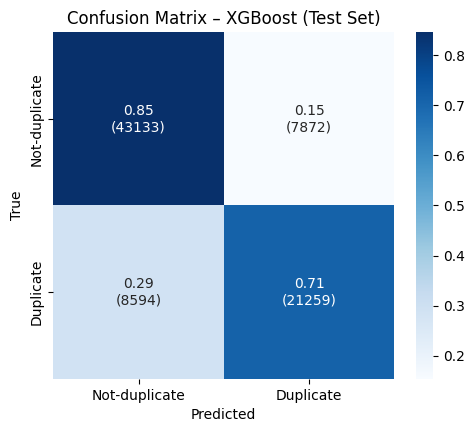

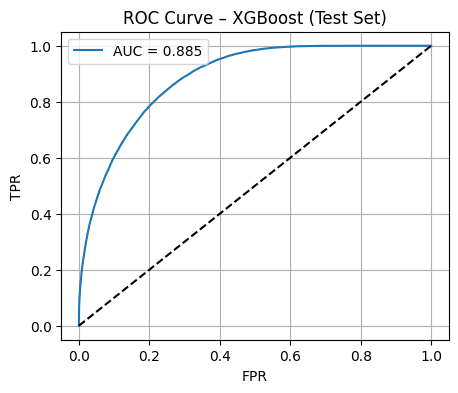

In [164]:
# Predict on test set
xgb_test_pred = xgb.predict(X_test)
xgb_test_proba = xgb.predict_proba(X_test)[:, 1]

# Evaluate on test set
display_metrics(df_test['is_duplicate'], xgb_test_pred, xgb_test_proba)

plot_confusion_matrix(
    df_test['is_duplicate'], xgb_test_pred,
    labels=['Not-duplicate', 'Duplicate'],
    title='Confusion Matrix – XGBoost (Test Set)'
)

plot_roc_curve(
    df_test['is_duplicate'], xgb_test_proba,
    title='ROC Curve – XGBoost (Test Set)'
)

### Let's use Glove embeddings instead of TFIDF embeddings.

In [165]:
zip_path = 'data/glove.6B.zip'
extract_path = 'data/glove_files'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

KeyboardInterrupt: 

In [171]:
# Updated path to extracted file
glove_path = 'data/glove_files/glove.6B.300d.txt'
embedding_dim = 300

# Read GloVe file
print("Loading GloVe embeddings...")
glove = {}
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        vec = np.array(parts[1:], dtype=np.float32)
        glove[word] = vec
print(f"Loaded {len(glove):,} word vectors.")

Loading GloVe embeddings...
Loaded 292,632 word vectors.


In [172]:
def preprocess_for_glove(doc):
    """
    Preprocess a spaCy Doc for GloVe-based embedding:
    - Lowercase and lemmatize alphabetic words
    - Keep numbers
    - Remove punctuation and stopwords
    - Avoid over-filtering to keep useful GloVe tokens

    Returns:
    --------
    str : space-separated cleaned tokens
    """

    if doc is None or (isinstance(doc, float) and np.isnan(doc)):
        return ""

    tokens = []
    for tok in doc:
        if tok.is_alpha:
            lemma = tok.lemma_.lower()
            if lemma == "-pron-":
                lemma = tok.text.lower()
            tokens.append(lemma)
        elif tok.like_num:
            tokens.append(tok.text)  # Keep numeric values

    return " ".join(tokens)

In [173]:
def average_glove_vector(text, glove, dim=300):
    words = text.split()
    vectors = [glove[word] for word in words if word in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

In [174]:
filtered_q1_glove = [preprocess_for_glove(doc) for doc in nlp.pipe(q1_texts, batch_size=1000)]
filtered_q2_glove = [preprocess_for_glove(doc) for doc in nlp.pipe(q2_texts, batch_size=1000)]

# Optionally store for inspection
df_train['filtered_q1_glove'] = filtered_q1_glove
df_train['filtered_q2_glove'] = filtered_q2_glove

In [175]:
q1_glove = df_train['filtered_q1_glove'].apply(lambda x: average_glove_vector(x, glove))
q2_glove = df_train['filtered_q2_glove'].apply(lambda x: average_glove_vector(x, glove))

In [176]:
q1_glove = np.vstack(q1_glove.values)
q2_glove = np.vstack(q2_glove.values)

In [177]:
df_glove = generate_engineered_features(df_train.copy(), q1_glove, q2_glove, vector_type='glove')

In [178]:
df_glove.head(2)

,qid1,qid2,question1,question2,is_duplicate,question1_word_count,question2_word_count,question1_character_count,question2_character_count,filtered_q1,...,filtered_q1_glove,filtered_q2_glove,token_jaccard_sim,word_count_ratio,char_count_ratio,same_start_word,char_ngram_sim,cosine_similarity,manhattan_dist,euclidean_dist
id,,,,,,,,,,,,,,,,,,,,,
332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three independent variables is also independent?,0,9,14,47,81,iliad odyssey greek culture,...,the iliad and the odyssey in the greek culture,how do i prove that the pair of three independent variable be also independent,0.050000,0.642857,0.580247,0,0.194243,0.675083,40.429928,2.942054
196656,297402,297403,What is practical management and what is strategic management?,What are the practical aspects of strategic management?,0,9,8,62,55,what practical management what strategic management,...,what be practical management and what be strategic management,what be the practical aspect of strategic management,0.363636,1.125000,1.127273,1,0.651558,0.945709,17.952959,1.340884


In [207]:
np.save("data/q1_glove.npy", q1_glove)
np.save("data/q2_glove.npy", q2_glove)

In [208]:
df_glove.to_csv("data/df_glove.csv", index=False)

is_duplicate         1.000000
char_ngram_sim       0.388363
token_jaccard_sim    0.340887
cosine_similarity    0.310720
same_start_word      0.197480
word_count_ratio    -0.054650
char_count_ratio    -0.068302
euclidean_dist      -0.315196
manhattan_dist      -0.315317
Name: is_duplicate, dtype: float64


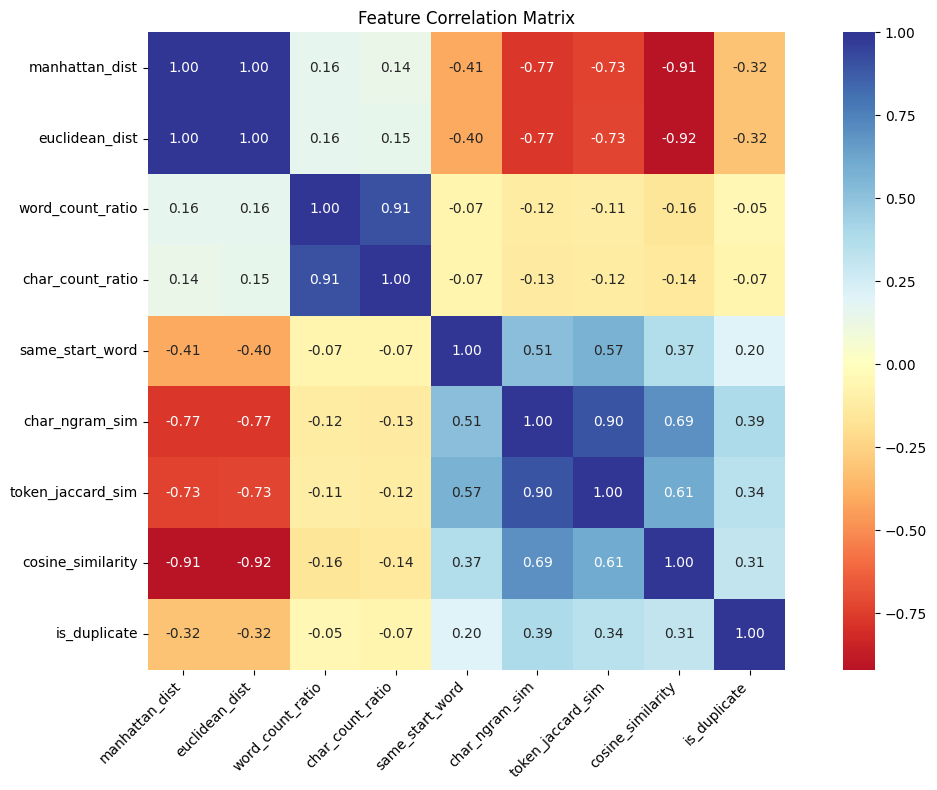

In [205]:
# Add target temporarily
features_with_target = feature_cols + ['is_duplicate']

# Correlation with target
correlations = df_glove[features_with_target].corr()['is_duplicate'].sort_values(ascending=False)
print(correlations)

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_glove[features_with_target].corr(), 
            cmap='RdYlBu', center=0,
            annot=True, fmt='.2f', square=True)
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
q1_df = pd.DataFrame(q1_glove.tolist(), index=df_train.index, columns=[f'q1_glove_{i}' for i in range(300)])
q2_df = pd.DataFrame(q2_glove.tolist(), index=df_train.index, columns=[f'q2_glove_{i}' for i in range(300)])

In [181]:
X_glove = pd.concat([df_glove[feature_cols], q1_df, q2_df], axis=1)
y = df_glove['is_duplicate']

In [194]:
scaler_glove = StandardScaler()

In [214]:
joblib.dump(scaler_glove, "data/scaler_glove.pkl")

['data/scaler_glove.pkl']

In [195]:
X_scaled_glove = scaler_glove.fit_transform(X_glove)

In [196]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled_glove, y, test_size=0.15, random_state=42, stratify=y)

### Logistic Regression with GloVe Features

Accuracy : 0.7248
Precision: 0.6436
Recall   : 0.5704
F1 Score : 0.6048
Log-Loss : 0.5163
ROC AUC  : 0.7996


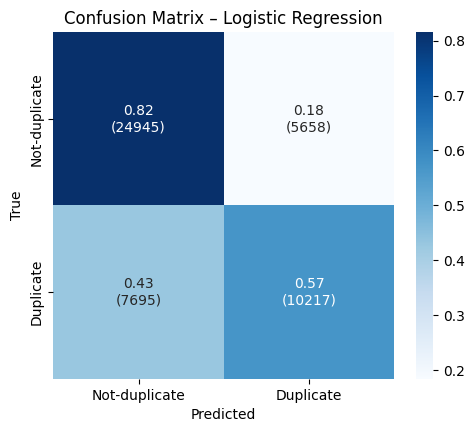

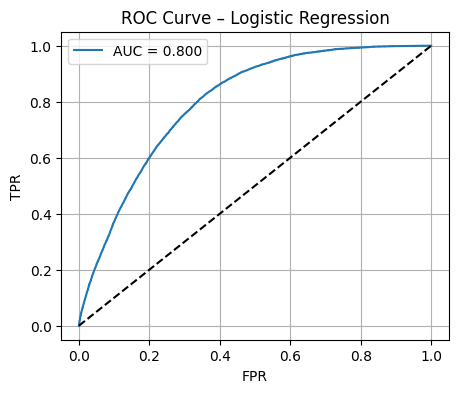

In [197]:
# Train logistic regression model
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr.predict(X_val)
y_proba = lr.predict_proba(X_val)[:, 1]

# Evaluate 
display_metrics(y_val, y_pred, y_proba)

plot_confusion_matrix(
    y_val, y_pred,
    labels=['Not-duplicate', 'Duplicate'],
    title='Confusion Matrix – Logistic Regression'
)

plot_roc_curve(
    y_val, y_proba,
    title='ROC Curve – Logistic Regression'
)

In [186]:
test_q1_texts = df_test["question1"].fillna("").tolist()
test_q2_texts = df_test["question2"].fillna("").tolist()

filtered_test_q1 = [preprocess_for_glove(doc) for doc in nlp.pipe(test_q1_texts, batch_size=1000)]
filtered_test_q2 = [preprocess_for_glove(doc) for doc in nlp.pipe(test_q2_texts, batch_size=1000)]

df_test["filtered_q1_glove"] = filtered_test_q1
df_test["filtered_q2_glove"] = filtered_test_q2

In [187]:
q1_test_glove = df_test["filtered_q1_glove"].apply(lambda x: average_glove_vector(x, glove))
q2_test_glove = df_test["filtered_q2_glove"].apply(lambda x: average_glove_vector(x, glove))

q1_test_glove = np.vstack(q1_test_glove.values)
q2_test_glove = np.vstack(q2_test_glove.values)

In [188]:
df_test_glove = generate_engineered_features(df_test.copy(), q1_test_glove, q2_test_glove, vector_type='glove')

In [198]:
q1_test_df = pd.DataFrame(q1_test_glove.tolist(), index=df_test.index, columns=[f'q1_glove_{i}' for i in range(300)])
q2_test_df = pd.DataFrame(q2_test_glove.tolist(), index=df_test.index, columns=[f'q2_glove_{i}' for i in range(300)])

In [199]:
X_test_glove = pd.concat([df_test_glove[feature_cols], q1_test_df, q2_test_df], axis=1)

#### Let's evaluate the model on the test dataset

In [215]:
X_test_glove_scaled = scaler_glove.transform(X_test_glove)

In [216]:
y_test = df_test_glove['is_duplicate'].values

y_test_pred = lr.predict(X_test_glove_scaled)
y_test_proba = lr.predict_proba(X_test_glove_scaled)[:, 1]

Accuracy : 0.7272
Precision: 0.6486
Recall   : 0.5698
F1 Score : 0.6067
Log-Loss : 0.5127
ROC AUC  : 0.8037


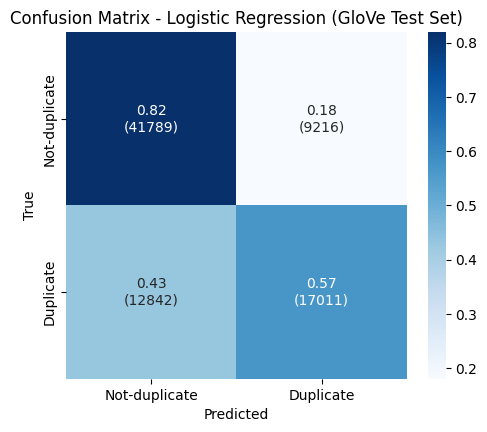

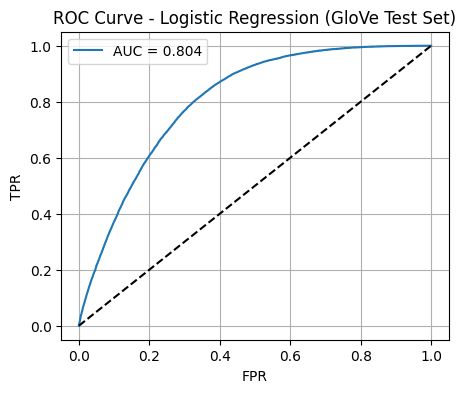

In [217]:
display_metrics(y_test, y_test_pred, y_test_proba)

plot_confusion_matrix(
    y_test, y_test_pred,
    labels=['Not-duplicate', 'Duplicate'],
    title='Confusion Matrix - Logistic Regression (GloVe Test Set)'
)

plot_roc_curve(
    y_test, y_test_proba,
    title='ROC Curve - Logistic Regression (GloVe Test Set)'
)

In [212]:
# Save the test GloVe vectors 
np.save("data/q1_test_glove.npy", q1_test_glove)
np.save("data/q2_test_glove.npy", q2_test_glove)

In [220]:
np.save("data/X_test_glove_scaled.npy", X_test_glove_scaled)
np.save("data/y_test.npy", y_test.astype(np.int64))

### XGBoost with GloVe Features

c:\Users\Galyna\anaconda3\envs\ml2025\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy : 0.7953
Precision: 0.7221
Recall   : 0.7242
F1 Score : 0.7231
Log-Loss : 0.4048
ROC AUC  : 0.8832


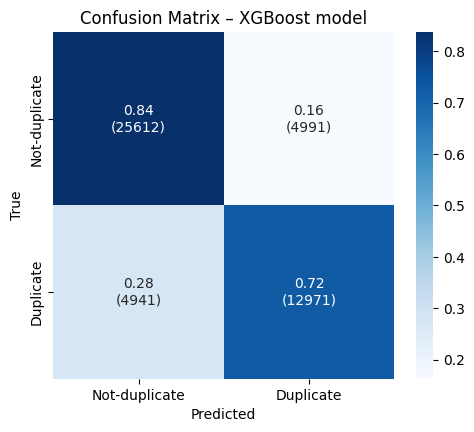

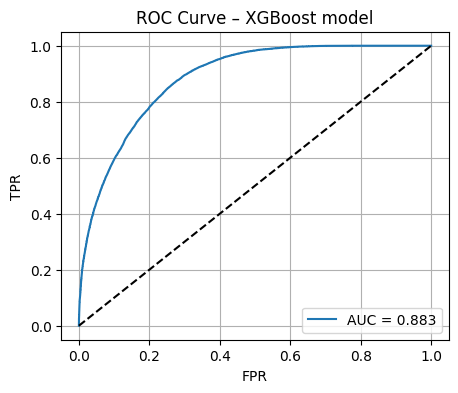

In [ ]:
# Train XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict and evaluate
xgb_test_pred = xgb.predict(X_test_glove_scaled)
xgb_test_proba = xgb.predict_proba(X_test_glove_scaled)[:, 1]

# Evaluate 
display_metrics(y_val, xgb_pred, xgb_proba)

plot_confusion_matrix(
    y_val, xgb_pred,
    labels=['Not-duplicate', 'Duplicate'],
    title='Confusion Matrix – XGBoost model'
)

plot_roc_curve(
    y_val, xgb_proba,
    title='ROC Curve – XGBoost model'
)

#### Let's evaluate the model on the test dataset

Accuracy : 0.7959
Precision: 0.7215
Recall   : 0.7283
F1 Score : 0.7249
Log-Loss : 0.4054
ROC AUC  : 0.8832


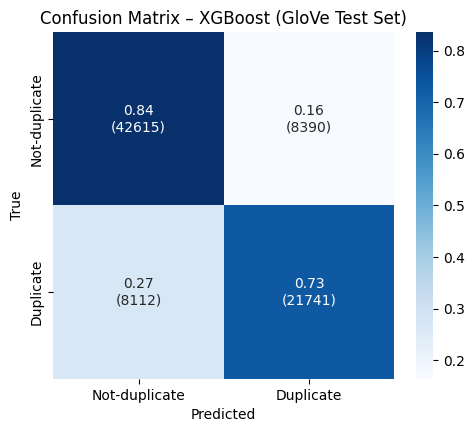

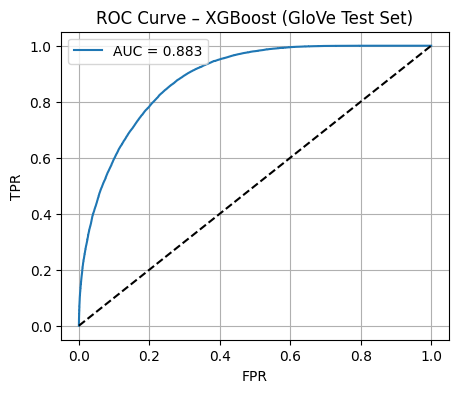

In [218]:
# Predict on test set
xgb_test_pred = xgb.predict(X_test_glove_scaled)
xgb_test_proba = xgb.predict_proba(X_test_glove_scaled)[:, 1]

# True labels
y_test = df_test_glove['is_duplicate'].values

# Evaluate on test set
display_metrics(y_test, xgb_test_pred, xgb_test_proba)

plot_confusion_matrix(
    y_test, xgb_test_pred,
    labels=['Not-duplicate', 'Duplicate'],
    title='Confusion Matrix – XGBoost (GloVe Test Set)'
)

plot_roc_curve(
    y_test, xgb_test_proba,
    title='ROC Curve – XGBoost (GloVe Test Set)'
)